In [621]:
# Carga de librerias
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn import svm
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [78]:
animal_info = pd.read_csv('data/train.csv', sep=',')

In [79]:
animal_info['AnimalID'].count()

26729

In [80]:
animal_info.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [81]:
# Cuantos son regresados a su dueño
return_to_owner = animal_info[animal_info['OutcomeType'] == 'Return_to_owner']
return_to_owner['AnimalID'].count()

4786

In [82]:
animal_info.describe(include='all')

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A664552,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [650]:
animal_type = []
for type_ in animal_info.AnimalType:
    if type_ == 'Dog':
        animal_type.append(0) # Dog
    else:
        animal_type.append(1) # Cat
animal_info['Type'] = animal_type
del animal_type

In [651]:
# Limpiar las variables Sex dividir en (Female/Male y Si puede reproducirse)
sex = []
can_have_descendants = []
for animal in animal_info.SexuponOutcome:
    if re.search(r"Male", str(animal)):
        sex.append(1)
    elif re.search(r"Female", str(animal)):
        sex.append(0)
    else:
        sex.append(-1)
    if re.search(r"Intact", str(animal)):
        can_have_descendants.append(1)
    elif re.search(r"Neutered", str(animal)) or re.search(r"Spayed",str(animal)):
        can_have_descendants.append(-1)
    else:
        can_have_descendants.append(0)

animal_info['Sex'] = sex
animal_info['CanHaveDescendants'] = can_have_descendants
#animal_info.head(5)

In [85]:
animal_info.Sex.value_counts(normalize=True) # cuantos machos/hembras son (gatos y perros)

 1    0.497737
 0    0.461334
-1    0.040929
Name: Sex, dtype: float64

In [86]:
animal_info.Sex.std()

0.5744609515872818

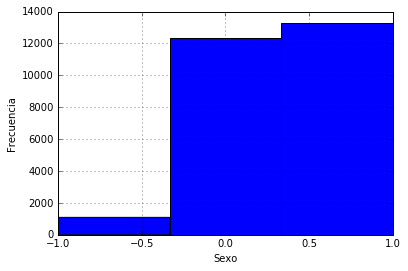

In [87]:
sex_animal = animal_info.Sex
sex_animal.hist(bins=3)
plt.xlabel('Sexo')
plt.ylabel('Frecuencia')

In [88]:
animal_info[animal_info.AnimalType == 'Dog'].Sex.value_counts() # la cantidad de perros (Male/Female/Unknwown)

 1    8312
 0    7205
-1      78
Name: Sex, dtype: int64

In [89]:
animal_info[animal_info.AnimalType == 'Dog'].SexuponOutcome.value_counts()

Neutered Male    6714
Spayed Female    5808
Intact Male      1598
Intact Female    1397
Unknown            77
Name: SexuponOutcome, dtype: int64

In [90]:
animal_info[animal_info.AnimalType == 'Cat'].Sex.value_counts() # la cantidad de perros (Male/Female/Unknwown)

 0    5126
 1    4992
-1    1016
Name: Sex, dtype: int64

In [91]:
animal_info[animal_info.AnimalType == 'Cat'].SexuponOutcome.value_counts()

Neutered Male    3065
Spayed Female    3012
Intact Female    2114
Intact Male      1927
Unknown          1016
Name: SexuponOutcome, dtype: int64

In [652]:
# Pasar la edad a dias
age_days = []
for age in animal_info.AgeuponOutcome:
    number = int(re.search(r'\d', age).group()) if re.search(r'\d', str(age)) else 0
    if re.search(r'\d week',str(age)):
        age_days.append(7 * number)
    elif re.search(r'\d month',str(age)):
        #print(28 * int(re.search(r"\d", age).group()), "days", age)
        age_days.append(28 * number)
    elif re.search(r'\d year',str(age)):
        #print(365 * int(re.search(r"\d", age).group()), "days", age)
        age_days.append(365 *  number)
    elif re.search(r'\d day',str(age)):
        age_days.append(number)
    else:
        age_days.append(-1)
animal_info['AgeDays'] = age_days
#animal_info.head(5)

In [93]:
std_age = animal_info.AgeDays.std()
std_age

751.6570434741138

In [653]:
# Definir la raza y sub-raza
breed_l = []
subbreed = []
for breed in animal_info.Breed:
    if '/' in breed:
        #print(breed[:breed.index('/')],breed[breed.index('/')+1:])
        breed_l.append(breed[:breed.index('/')])
        subbreed.append(breed[breed.index('/')+1:])
    elif 'Mix' in breed:
        #print(breed[:-4],'|', breed[-4:])
        breed_l.append(breed[:-4])
        #subbreed.append(breed[breed.index('/')+1:])
        subbreed.append('Mix')
    else:
        breed_l.append(breed)
        subbreed.append('')
animal_info['Breed1'] = breed_l
animal_info['Subbreed'] = subbreed
#animal_info.head(5)
#print(len(breed_l), len(subbreed))
#breed_l

In [654]:
is_mix = []
for breed in animal_info.Breed:
    if 'Mix' in breed:
        is_mix.append(1)
    else:
        is_mix.append(0)
animal_info['IsMix'] = is_mix
#animal_info.head(5)
#print(len(breed_l), len(subbreed))
#breed_l

In [95]:
animal_info.corr()

,Type,Sex,CanHaveDescendants,AgeDays
Type,1.000000,-0.146652,0.240176,-0.274193
Sex,-0.146652,1.000000,-0.072047,0.070804
CanHaveDescendants,0.240176,-0.072047,1.000000,-0.208467
AgeDays,-0.274193,0.070804,-0.208467,1.000000


In [96]:
animal_info.AgeDays.mean() / 365 # la edad promedio de los animales

1.6606897131380056

In [146]:
is_adopted = []
for outcome_type in animal_info.OutcomeType:
    if outcome_type == 'Adoption':
        is_adopted.append(1)
    else:
        is_adopted.append(0)
animal_info['IsAdopted'] = is_adopted

In [157]:
dog_ = animal_info[animal_info.AnimalType == 'Dog']
dogs = dog_[['Sex', 'CanHaveDescendants', 'AgeDays','Breed1','Subbreed','IsMix','IsAdopted']]
del dog_
cat_ = animal_info[animal_info.AnimalType == 'Cat']
cats = cat_[['Sex', 'CanHaveDescendants', 'AgeDays','Breed1','Subbreed','IsMix','IsAdopted']]
del cat_

In [158]:
dogs_adopted = dogs[dogs.IsAdopted == 1]
cats_adopted = cats[cats.IsAdopted == 1]

In [159]:
# canhavedescendants VS isadopted DOGS
len(dogs_adopted[dogs_adopted.CanHaveDescendants == -1]) # No puede tener descendencia

6374

In [160]:
len(dogs_adopted[dogs_adopted.CanHaveDescendants == 0]) # Unknown

0

In [161]:
len(dogs_adopted[dogs_adopted.CanHaveDescendants == 1]) # Puede tener descendencia

123

In [162]:
# canhavedescendants VS isadopted CATS
len(cats_adopted[cats_adopted.CanHaveDescendants == -1]) # No puede tener descendencia

4034

In [153]:
len(cats_adopted[cats_adopted.CanHaveDescendants == 0]) # Unknown

0

In [154]:
len(cats_adopted[cats_adopted.CanHaveDescendants == 1]) # Puede tener descendencia

238

In [210]:
# AgeDays VS IsAdopted (Dogs)
dogs_adopted.AgeDays.describe()

count    6497.000000
mean      634.515469
std       705.649098
min        28.000000
25%       112.000000
50%       365.000000
75%       730.000000
max      3285.000000
Name: AgeDays, dtype: float64

In [208]:
# Obteniendo la edad maxima de un perro adoptado (en anios)
dogs_adopted.AgeDays.max() / 365

9.0

In [209]:
# Obteniendo la edad minima de un perro adoptado (en dias)
dogs_adopted.AgeDays.min()

28

In [213]:
# el promedio de la edad de un perro adoptado (en anios)
dogs_adopted.AgeDays.mean() / 365

1.7383985443228804

In [217]:
# AgeDays VS IsAdopted (Cats)
cats_adopted.AgeDays.describe()

count    4272.000000
mean      305.815777
std       595.452204
min        28.000000
25%        56.000000
50%        84.000000
75%       196.000000
max      3285.000000
Name: AgeDays, dtype: float64

In [216]:
# Obteniendo la edad maxima de un gato adoptado (en anios)
cats_adopted.AgeDays.max() / 365

9.0

In [218]:
# Obteniendo la edad minima de un gato adoptado (en dias)
cats_adopted.AgeDays.min()

28

In [226]:
# el promedio de la edad de un gato adoptado (en meses)
#cats_adopted.AgeDays.mean() / 365
cats_adopted.AgeDays.mean() / 365 * 12

10.054217331075881

In [604]:
dogs_data_training = dogs[['Sex','CanHaveDescendants', 'IsMix']]
dogs_output_training = dogs['IsAdopted']

In [623]:
clf = svm.SVC()
clf.fit(dogs_data_training, dogs_output_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [644]:
dogs_pred = clf.predict(dogs_data_training)

In [647]:
confusion_matrix(dogs_output_training, dogs_pred, labels=[0,1])

array([[5503, 3595],
       [2390, 4107]])

In [648]:
cats_data_training = cats[['Sex','CanHaveDescendants', 'IsMix']]
cats_output_training = cats['IsAdopted']
clf_cat = svm.SVC()
clf_cat.fit(cats_data_training, cats_output_training)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [649]:
cats_pred = clf_cat.predict(cats_data_training)
confusion_matrix(cats_output_training, cats_pred, labels=[0,1])

array([[4819, 2043],
       [ 238, 4034]])